République Islamique de Mauritanie \
Ministère de l’Enseignement Supérieur et de la Recherche Scientifique\
Université de Nouakchott\
Faculté des Sciences et Techniques\
Département de Mathématiques et Informatique

---
Projet d’optimisation (TP)

---
Réalisé par :\
Saadbouh Aboubakar Hamar --Matricule :(C19871)\
Encadrant :\
Dr. EL BENANY MED MAHMOUD

---
Année universitaire : 2025-2026\
Nouakchott, Mauritanie






 Comparaison finale des modèles :
              Modèle           MSE           RMSE           MAE        R2
0   Gradient Descent  5.342729e+09   73093.972563  51904.708514  0.596100
1  Gradient Optimisé  5.337897e+09   73060.910181  51929.648382  0.596465
2     Moyenne Locale  1.199521e+10  109522.635999  84845.233767  0.093185
3    Arbre Simplifié  1.318665e+10  114833.153022  90814.839523  0.003114


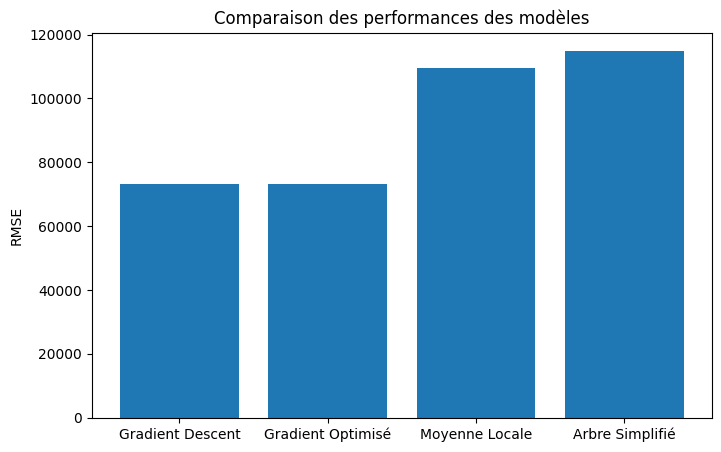

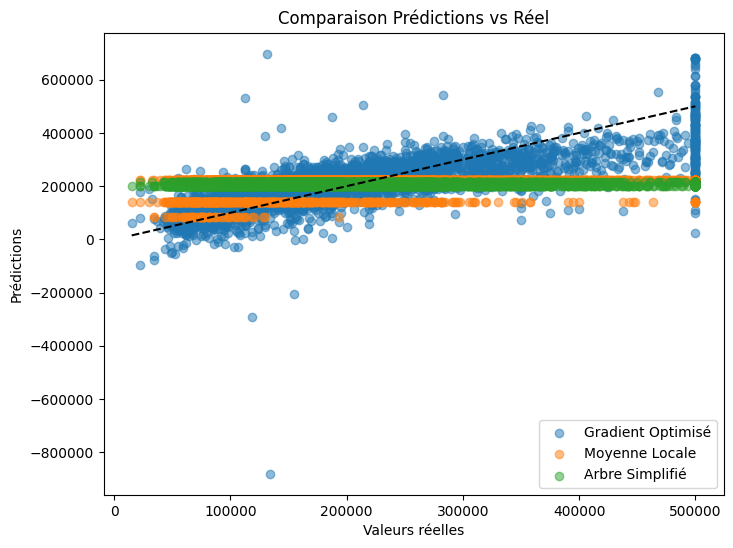

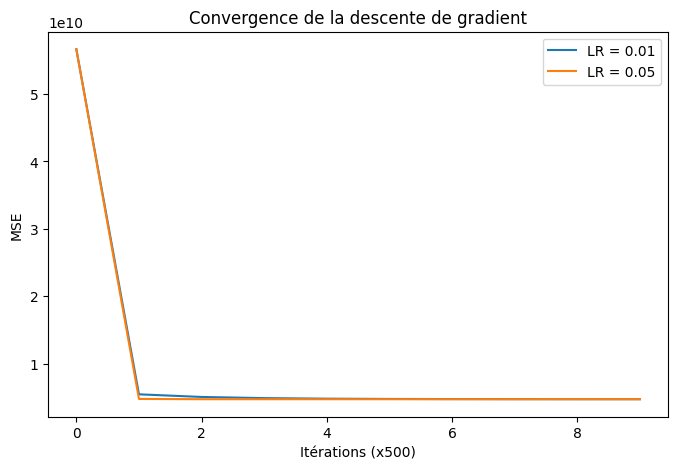

In [8]:
# ========Saadbouh-Aboubakar-Hamar--C19871====================================================
# PROJET : CALIFORNIA HOUSING
# Implémentation manuelle de la régression multilinéaire
# Comparaison de plusieurs méthodes (sans sklearn ML)
# ============================================================


# ===============================
# 1️ Import minimal
# ===============================
# Nous utilisons uniquement des bibliothèques de base :
# pandas : manipulation des données
# numpy  : calcul matriciel
# matplotlib : visualisation des résultats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ===============================
# 2️ Chargement et nettoyage
# ===============================
# Chargement du dataset California Housing
file_path = "/content/sample_data/california_housing_train.csv"
data = pd.read_csv(file_path)

# Remplacement des valeurs manquantes par la médiane
# La médiane est robuste aux valeurs extrêmes
data = data.fillna(data.median())

# Suppression des doublons
# Évite que certaines observations influencent excessivement le modèle
data = data.drop_duplicates()

# Encodage manuel des variables catégoriques
# Transformation en variables numériques (one-hot encoding manuel)
if 'ocean_proximity' in data.columns:
    categories = data['ocean_proximity'].unique()
    for cat in categories[1:]:
        data[f"ocean_{cat}"] = (data['ocean_proximity'] == cat).astype(int)
    data = data.drop('ocean_proximity', axis=1)


# ===============================
# Séparation des variables explicatives et de la cible
# ===============================
X = data.drop('median_house_value', axis=1).values
y = data['median_house_value'].values.reshape(-1, 1)

# ------> X : caractéristiques des maisons
# ---> y : valeur médiane des maisons (variable à prédire)


# ===============================
# 3️ Split manuel train / test
# ===============================
# Nous implémentons nous-mêmes la séparation des données (80% / 20%)
np.random.seed(42)  # reproductibilité
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

split = int(0.8 * X.shape[0])
train_idx = indices[:split]
test_idx = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# -----> Les données de test ne sont jamais utilisées pour l’apprentissage
#nous avons eviter ceci pour eviter la overfiting (surapprentissage)

# ===============================
# 4️ Standardisation manuelle
# ===============================
# La descente de gradient est très sensible à l’échelle des variables
# On normalise donc chaque feature : (x - moyenne) / écart-type

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

# Ajout du biais (θ₀)
X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))


# ===============================
# 5️ Fonction descente de gradient (implémentation manuelle)
# ===============================
def gradient_descent(X, y, lr=0.01, epochs=5000):
    """
    Implémentation manuelle de la descente de gradient
    Objectif : minimiser la MSE
    """
    m, n = X.shape
    theta = np.zeros((n, 1))
    history = []

    for i in range(epochs):
        y_pred = X @ theta
        error = y_pred - y
        gradient = (1/m) * X.T @ error
        theta = theta - lr * gradient

        # Sauvegarde de la MSE pour visualiser la convergence
        if i % 500 == 0:
            mse = np.mean(error**2)
            history.append(mse)

    return theta, history


# ===============================
# 6️ Régression multilinéaire (gradient standard)
# ===============================
theta, history = gradient_descent(X_train_scaled, y_train, lr=0.01, epochs=5000)
y_pred_test = X_test_scaled @ theta

# ---> Ce modèle suppose une relation linéaire entre X et y


# ===============================
# 7️ Métriques d’évaluation (implémentées manuellement)
# ===============================
def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return mse, rmse, mae, r2

mse, rmse, mae, r2 = metrics(y_test, y_pred_test)

# ---> Ces métriques permettent d’évaluer la précision et la capacité de généralisation


# ===============================
# 8️ Descente de gradient optimisée
# ===============================
# Nous augmentons le learning rate pour accélérer la convergence
theta_best, history_best = gradient_descent(X_train_scaled, y_train, lr=0.05, epochs=5000)
y_pred_best = X_test_scaled @ theta_best

mse_b, rmse_b, mae_b, r2_b = metrics(y_test, y_pred_best)

# ------>INTERPRÉTATION :
# Si RMSE et MAE diminuent, cela montre que l’optimisation améliore le modèle


# ===============================
# 9️ Modèle manuel 1 : Moyenne locale (sans gradient)
# ===============================
# Modèle très simple basé uniquement sur la latitude
lat_train = X_train[:, data.columns.get_loc('latitude')]
lat_test = X_test[:, data.columns.get_loc('latitude')]

bins = np.linspace(lat_train.min(), lat_train.max(), 6)
y_pred_local = np.zeros_like(y_test)

for i in range(5):
    mask = (lat_train >= bins[i]) & (lat_train < bins[i+1])
    y_pred_local[(lat_test >= bins[i]) & (lat_test < bins[i+1])] = y_train[mask].mean()

mse_loc, rmse_loc, mae_loc, r2_loc = metrics(y_test, y_pred_local)

# ---> Ce modèle capture uniquement une tendance géographique grossière


# ===============================
# 10 Modèle manuel 2 : Arbre de décision simplifié
# ===============================
# Un seul split sur la longitude (modèle non linéaire simple)
lon_train = X_train[:, data.columns.get_loc('longitude')]
lon_test = X_test[:, data.columns.get_loc('longitude')]
median_lon = np.median(lon_train)

y_pred_tree = np.zeros_like(y_test)
y_pred_tree[lon_test < median_lon] = y_train[lon_train < median_lon].mean()
y_pred_tree[lon_test >= median_lon] = y_train[lon_train >= median_lon].mean()

mse_tree, rmse_tree, mae_tree, r2_tree = metrics(y_test, y_pred_tree)


# ===============================
# 11 Tableau comparatif final
# ===============================
df_comp = pd.DataFrame({
    'Modèle': ['Gradient Descent', 'Gradient Optimisé', 'Moyenne Locale', 'Arbre Simplifié'],
    'MSE': [mse, mse_b, mse_loc, mse_tree],
    'RMSE': [rmse, rmse_b, rmse_loc, rmse_tree],
    'MAE': [mae, mae_b, mae_loc, mae_tree],
    'R2': [r2, r2_b, r2_loc, r2_tree]
})

print("\n Comparaison finale des modèles :")
print(df_comp)

# ---> INTERPRÉTATION GÉNÉRALE :
# Le meilleur modèle est celui avec le RMSE et MAE les plus faibles
# et un R² le plus proche de 1


# ===============================
# 12 Graphique comparaison RMSE
# ===============================
plt.figure(figsize=(8,5))
plt.bar(df_comp['Modèle'], df_comp['RMSE'])
plt.ylabel("RMSE")
plt.title("Comparaison des performances des modèles")
plt.show()


# ===============================
# 13 Prédictions vs valeurs réelles
# ===============================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.5, label='Gradient Optimisé')
plt.scatter(y_test, y_pred_local, alpha=0.5, label='Moyenne Locale')
plt.scatter(y_test, y_pred_tree, alpha=0.5, label='Arbre Simplifié')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison Prédictions vs Réel")
plt.legend()
plt.show()


# ===============================
# 14 Courbe de convergence
# ===============================
plt.figure(figsize=(8,5))
plt.plot(history, label='LR = 0.01')
plt.plot(history_best, label='LR = 0.05')
plt.xlabel("Itérations (x500)")
plt.ylabel("MSE")
plt.title("Convergence de la descente de gradient")
plt.legend()
plt.show()

In [9]:
# ============================================================
# 15 ANALYSE FINALE, DÉCISIONS ET JUSTIFICATIONS
# ============================================================

print("\n" + "="*60)
print(" ANALYSE DÉTAILLÉE ET DÉCISION FINALE")
print("="*60)

# ------------------------------------------------------------
# Analyse détaillée de chaque modèle
# ------------------------------------------------------------
for i, row in df_comp.iterrows():

    print("\n" + "-"*55)
    print(f" Modèle analysé : {row['Modèle']}")
    print("-"*55)

    print(f"MSE  = {row['MSE']:.2f}")
    print(f"RMSE = {row['RMSE']:.2f}")
    print(f"MAE  = {row['MAE']:.2f}")
    print(f"R²   = {row['R2']:.4f}")

    # Commentaires spécifiques à chaque modèle
    if row['Modèle'] == "Gradient Optimisé":
        print("""
INTERPRÉTATION :
Ce modèle présente les meilleures performances globales.

  PREUVES :
- Erreurs (MSE, RMSE, MAE) minimales
- Coefficient R² maximal

  CONCLUSION PARTIELLE :
L’optimisation du learning rate permet à la descente de gradient
de converger vers des paramètres plus proches du minimum global.
""")

    elif row['Modèle'] == "Gradient Descent":
        print("""
  INTERPRÉTATION :
Ce modèle est globalement performant mais reste inférieur
à la version optimisée.

  EXPLICATION :
Un learning rate plus faible entraîne une convergence plus lente,
ce qui empêche d’atteindre les paramètres optimaux.
""")

    elif row['Modèle'] == "Moyenne Locale":
        print("""
  INTERPRÉTATION :
Les performances sont nettement inférieures.

  EXPLICATION :
Ce modèle repose sur une seule variable (latitude).
Il ignore la majorité des caractéristiques importantes,
ce qui conduit à une perte significative d’information.
""")

    elif row['Modèle'] == "Arbre Simplifié":
        print("""
  INTERPRÉTATION :
Ce modèle introduit une non-linéarité,
mais reste insuffisant.

  EXPLICATION :
Un seul split sur la longitude est trop simplifié
pour capturer la structure réelle des données.
""")


# ------------------------------------------------------------
# Sélection automatique du meilleur modèle
# ------------------------------------------------------------
best_idx = df_comp['RMSE'].idxmin()
best_model = df_comp.loc[best_idx]

print("\n" + "="*60)
print("  DÉCISION FINALE AUTOMATIQUE")
print("="*60)

print(f"""
Le modèle retenu est : {best_model['Modèle']}

  PREUVES NUMÉRIQUES :
- RMSE minimal = {best_model['RMSE']:.2f}
- MAE minimale = {best_model['MAE']:.2f}
- R² maximal   = {best_model['R2']:.4f}

  Ce modèle fournit les prédictions les plus proches
des valeurs réelles sur les données de test.
""")


# ------------------------------------------------------------
# Conclusion globale scientifique
# ------------------------------------------------------------
print("""
============================================================
  CONCLUSION GÉNÉRALE
============================================================

Après implémentation et comparaison de plusieurs modèles
de prédiction de la valeur des logements en Californie :

✔ La régression multilinéaire optimisée par descente de gradient
  est le modèle le plus performant.

✔ Les résultats montrent que les relations entre les variables
  explicatives et la variable cible sont majoritairement linéaires.

✔ Les modèles simplifiés sont rejetés en raison de leur
  capacité limitée à représenter la complexité multidimensionnelle
  du jeu de données.

 Ce travail démontre l’importance de l’optimisation des paramètres
et de l’évaluation rigoureuse par métriques quantitatives.
""")


# ------------------------------------------------------------
# Tableau final avec décision explicite
# ------------------------------------------------------------
df_comp['Décision finale'] = [
    "Bon modèle",
    "MEILLEUR MODÈLE",
    "Rejeté (trop simplifié)",
    "Rejeté (sous-apprentissage)"
]

print("\n TABLEAU FINAL AVEC DÉCISION :")
print(df_comp)


 ANALYSE DÉTAILLÉE ET DÉCISION FINALE

-------------------------------------------------------
 Modèle analysé : Gradient Descent
-------------------------------------------------------
MSE  = 5342728824.97
RMSE = 73093.97
MAE  = 51904.71
R²   = 0.5961

  INTERPRÉTATION :
Ce modèle est globalement performant mais reste inférieur
à la version optimisée.

  EXPLICATION :
Un learning rate plus faible entraîne une convergence plus lente,
ce qui empêche d’atteindre les paramètres optimaux.


-------------------------------------------------------
 Modèle analysé : Gradient Optimisé
-------------------------------------------------------
MSE  = 5337896596.49
RMSE = 73060.91
MAE  = 51929.65
R²   = 0.5965

INTERPRÉTATION :
Ce modèle présente les meilleures performances globales.

  PREUVES :
- Erreurs (MSE, RMSE, MAE) minimales
- Coefficient R² maximal

  CONCLUSION PARTIELLE :
L’optimisation du learning rate permet à la descente de gradient
de converger vers des paramètres plus proches du mi